In [91]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

from wordcloud import WordCloud

import seaborn as sns
import matplotlib.pyplot as plt

from utils import init_random_seed, tokenize_text_simple_regex

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
SEED = 1
TRAIN_MODEL = False # if True, then train model and save it. if False, just load it
PATH_MODEL = "./Pre-trained Models/tfidf_xgb_last_performer.pkl"
PATH_DATASET = './Data/Dataset_cleaned.csv'

In [93]:
init_random_seed(SEED)

In [94]:
dataset = pd.read_csv(PATH_DATASET).iloc[:, 1:]
dataset.head()

,Application description,Last performer
0,На трассе Нижнекамск-Чистополь в лесополосе у ...,Исполнительный комитет Нижнекамского муниципал...
1,Во дворе дома Ленинградская 29 отсутствуют пар...,Исполнительный комитет Лениногорского муниципа...
2,Добрый день! Не осуществляется уборка снега в ...,Администрация Вахитовского и Приволжского райо...
3,Добрый день! Не осуществляется вывоз мусора с ...,Администрация Кировского и Московского района ...
4,на данном участке проезжей части от ул.Халитов...,Администрация Советского района г.Казани


In [95]:
last_performer_int = LabelEncoder().fit_transform(dataset['Last performer'])
print(f"Unique classes of the variable Last performer: {len(dataset['Last performer'].unique())}")

Unique classes of the variable Last performer: 67


In [96]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset['Application description'],
    last_performer_int,
    test_size=0.3,
    shuffle=True,
    stratify=last_performer_int,
    random_state=SEED
)

In [97]:
MAX_DF = 0.8
MIN_COUNT = 5
MIN_TOKEN_SIZE = 4

tfidf_vectorizer = TfidfVectorizer(
    tokenizer=lambda text: tokenize_text_simple_regex(text, min_token_size=MIN_TOKEN_SIZE),
    max_df=MAX_DF,
    min_df=MIN_COUNT,
    token_pattern=None,
    lowercase=False
)

X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)
X_train.shape, X_test.shape

((17159, 6139), (7355, 6139))

In [98]:
print('Ненулевые элементы в тренировочной выборке:', X_train.nnz)
print('Процент заполненности матрицы признаков {:.2f}%\n'.format(X_train.nnz * 100 / (X_train.shape[0] * X_train.shape[1])))

print('Ненулевые элементы в тестовой выборке:', X_test.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(X_test.nnz * 100 / (X_test.shape[0] * X_test.shape[1])))

Ненулевые элементы в тренировочной выборке: 186576
Процент заполненности матрицы признаков 0.18%

Ненулевые элементы в тестовой выборке: 78135
Процент заполненности матрицы признаков 0.17%


In [99]:
word_frequencies = pd.DataFrame({
    'word': tfidf_vectorizer.get_feature_names_out(),
    'frequency': X_train.toarray().sum(axis=0)
}).sort_values(by='frequency', ascending=False)[:200]

In [100]:
wordcloud_application_description = WordCloud(
    background_color='black',
    colormap='Oranges',
    max_words=200,
    mask=None,
    width=1600,
    height=1600,
).generate_from_frequencies(dict(word_frequencies.values))

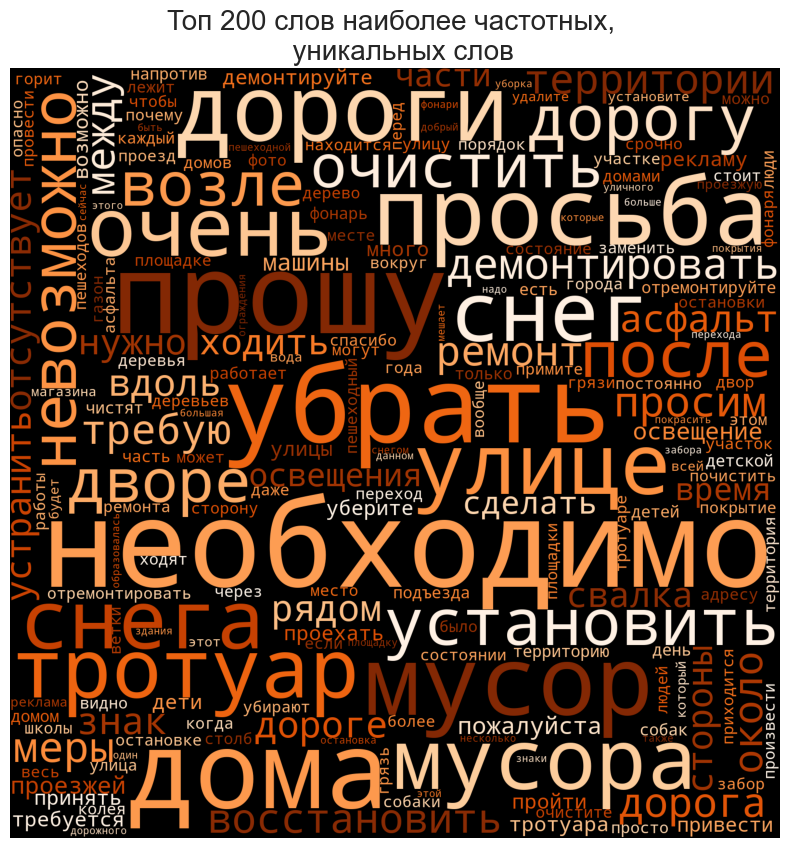

In [101]:
plt.figure(figsize=(15, 10))

plt.title(
    'Топ ' + str(word_frequencies.shape[0]) + \
    ' слов наиболее частотных, \n ' + \
    ' уникальных слов',
    fontsize=20
)

plt.axis('off')
plt.imshow(wordcloud_application_description);

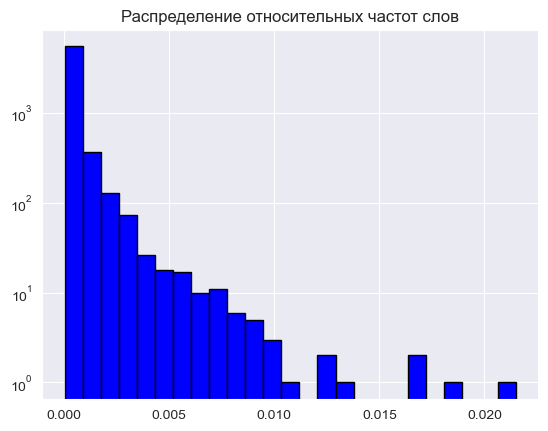

In [102]:
plt.hist(np.mean(X_train.toarray(), axis=0), bins=25, color='blue', edgecolor='black')
plt.title('Распределение относительных частот слов')
plt.yscale('log');

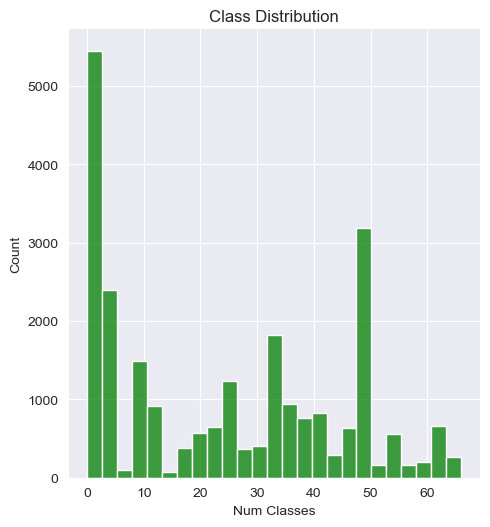

In [103]:
sns.displot(last_performer_int, color='green')
plt.xlabel('Num Classes')
plt.title('Class Distribution');

In [104]:
parameters = {
    'objective': 'multi:softprob',
    'learning_rate': 1.0e-1,
    'n_estimators': 1000,
    'early_stopping_rounds': 15,
    'max_depth': 5,
    'subsample': 0.5,
    'eval_metric': ['merror', 'auc'],
    'verbosity': 1,
    'seed': SEED
}

if TRAIN_MODEL:
    xgb_clf = XGBClassifier(**parameters)
    
    xgb_clf.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)]
    )

    pickle.dump(xgb_clf, open(PATH_MODEL, "wb"))
else:
    xgb_clf = pickle.load(open(PATH_MODEL, 'rb'))

In [105]:
train_pred_proba = xgb_clf.predict_proba(X_train)
test_pred_proba = xgb_clf.predict_proba(X_test)
test_pred = xgb_clf.predict(X_test)

print(f"AUC Train: {roc_auc_score(y_train, train_pred_proba, multi_class='ovr'):.4f}\n"
      f"AUC Test: {roc_auc_score(y_test, test_pred_proba, multi_class='ovr'):.4f}\n"
      f"Accuracy score on Test: {accuracy_score(y_test, test_pred):.4f}")

AUC Train: 0.9661
AUC Test: 0.7735
Accuracy score on Test: 0.3016
